In [1]:
! pip install langchain_community tiktoken langchain-openai langchainhub chromadb langchain langgraph tavily-python

INFO: pip is looking at multiple versions of langgraph to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of langgraph to determine which version is compatible with other requirements. This could take a while.
INFO: This is taking longer than usual. You might need to provide the dependency resolver with stricter constraints to reduce runtime. See https://pip.pypa.io/warnings/backtracking for guidance. If you want to abort this run, press Ctrl + C.
   ---------------------------------------- 83.5/83.5 kB 666.4 kB/s eta 0:00:00


In [17]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import Chroma
from langchain_cohere import  CohereEmbeddings
from langchain_community.document_loaders import  PyPDFLoader


loader=PyPDFLoader("gc.pdf")
docs=loader.load()
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1024, chunk_overlap=16)

splits = text_splitter.split_documents(docs)
print(len(splits))

# Add to vectorDB
vectorstore = Chroma.from_documents(
    documents=splits,
    collection_name="rag-chroma",
    embedding=CohereEmbeddings(),
    persist_directory="./chroma_db"
)


349


In [48]:
retriever = vectorstore.as_retriever(search_kwargs={"k": 10})

In [43]:
sim=vectorstore.similarity_search("What are the Green IT Drivers",search_kwargs={"k": 100})
print(len(sim))

TypeError: Collection.query() got an unexpected keyword argument 'search_kwargs'

In [8]:
!pip install -U langchain-anthropic

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
langchain 0.1.20 requires langchain-core<0.2.0,>=0.1.52, but you have langchain-core 0.2.5 which is incompatible.
langchain-community 0.0.38 requires langchain-core<0.2.0,>=0.1.52, but you have langchain-core 0.2.5 which is incompatible.
langchain-openai 0.0.5 requires langchain-core<0.2,>=0.1.16, but you have langchain-core 0.2.5 which is incompatible.


   ---------------------------------------- 0.0/862.7 kB ? eta -:--:--
   ------ --------------------------------- 143.4/862.7 kB 2.8 MB/s eta 0:00:01
   --------------- ------------------------ 337.9/862.7 kB 2.6 MB/s eta 0:00:01
   ----------------------------- ---------- 634.9/862.7 kB 2.9 MB/s eta 0:00:01
   ---------------------------------- ----- 747.5/862.7 kB 2.8 MB/s eta 0:00:01
   ---------------------------------------  860.2/862.7 kB 2.9 MB/s eta 0:00:01
   ---------------------------------------  860.2/862.7 kB 2.9 MB/s eta 0:00:01
   ---------------------------------------- 862.7/862.7 kB 2.0 MB/s eta 0:00:00
   ---------------------------------------- 0.0/314.7 kB ? eta -:--:--
   -------------------- ------------------- 163.8/314.7 kB 9.6 MB/s eta 0:00:01
   ---------------------------------------  307.2/314.7 kB 4.8 MB/s eta 0:00:01
   ---------------------------------------  307.2/314.7 kB 4.8 MB/s eta 0:00:01
   ---------------------------------------  307.2/314.7 kB

In [49]:
### Retrieval Grader

from typing import Literal

from langchain_core.prompts import ChatPromptTemplate
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_anthropic import ChatAnthropic


# Data model
class GradeDocuments(BaseModel):
    """Binary score for relevance check on retrieved documents."""

    binary_score: str = Field(
        description="Documents are relevant to the question, 'yes' or 'no'"
    )


# LLM with function call
llm = ChatAnthropic(model="claude-3-haiku-20240307")
structured_llm_grader = llm.with_structured_output(GradeDocuments)

# Prompt
system = """You are a grader assessing relevance of a retrieved document to a user question. \n 
    It does not need to be a stringent test. The goal is to filter out erroneous retrievals. \n
    If the document contains keyword(s) or semantic meaning related to the user question, grade it as relevant. \n
    Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question."""
grade_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "Retrieved document: \n\n {document} \n\n User question: {question}"),
    ]
)

retrieval_grader = grade_prompt | structured_llm_grader
question = "Green IT Drivers"
docs = retriever.get_relevant_documents(question)
print(len(docs))
doc_txt = docs[0].page_content
print(doc_txt)
print(retrieval_grader.invoke({"question": question, "document": doc_txt}))

10
Green IT is defined as ― the study and practice of designing, manufacturing, using and disposing 
of computers, servers and associated subsystems (such as monitors, printers,storage devices, and 
networking and communication systems) efficiently and effectively with minimal or no imoact on the 
environment.‖  
THE ENVIRONMENT TODAY 
 As mentioned earlier, whether human activity is the cause of change in the environment or not 
becomes a background conversation to improving business and achieving environmental outcomes In the 
process. It is this business-driven collaborative path that opens opportunity for corporate action.
 
www.rejinpaul.com
binary_score='yes'


In [50]:
### Generate

from langchain import hub
from langchain_core.output_parsers import StrOutputParser

# Prompt
prompt = hub.pull("rlm/rag-prompt")

# LLM
llm = ChatAnthropic(model="claude-3-haiku-20240307")



# Post-processing
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)


# Chain
rag_chain = prompt | llm | StrOutputParser()

# Run
generation = rag_chain.invoke({"context": docs, "question": question})
print(generation)

According to the provided context, the key drivers for Green IT include:

1. Cost reduction through improved energy efficiency, reduced raw material and equipment usage, recycling, and optimized storage and inventory.
2. Regulatory and legal requirements set by the government.
3. Sociocultural and political factors, new market opportunities, enlightened self-interest, and a responsible business ecosystem.


In [51]:
### Hallucination Grader


# Data model
class GradeHallucinations(BaseModel):
    """Binary score for hallucination present in generation answer."""

    binary_score: str = Field(
        description="Answer is grounded in the facts, 'yes' or 'no'"
    )


# LLM with function call
llm = ChatAnthropic(model="claude-3-haiku-20240307")

structured_llm_grader = llm.with_structured_output(GradeHallucinations)

# Prompt
system = """You are a grader assessing whether an LLM generation is grounded in / supported by a set of retrieved facts. \n 
     Give a binary score 'yes' or 'no'. 'Yes' means that the answer is grounded in / supported by the set of facts."""
hallucination_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "Set of facts: \n\n {documents} \n\n LLM generation: {generation}"),
    ]
)

hallucination_grader = hallucination_prompt | structured_llm_grader
hallucination_grader.invoke({"documents": docs, "generation": generation})

GradeHallucinations(binary_score='yes')

In [52]:
### Answer Grader


# Data model
class GradeAnswer(BaseModel):
    """Binary score to assess answer addresses question."""

    binary_score: str = Field(
        description="Answer addresses the question, 'yes' or 'no'"
    )


# LLM with function call
llm = ChatAnthropic(model="claude-3-haiku-20240307")

structured_llm_grader = llm.with_structured_output(GradeAnswer)

# Prompt
system = """You are a grader assessing whether an answer addresses / resolves a question \n 
     Give a binary score 'yes' or 'no'. Yes' means that the answer resolves the question."""
answer_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "User question: \n\n {question} \n\n LLM generation: {generation}"),
    ]
)

answer_grader = answer_prompt | structured_llm_grader
answer_grader.invoke({"question": question, "generation": generation})

GradeAnswer(binary_score='yes')

In [53]:
### Question Re-writer

# LLM
llm = ChatAnthropic(model="claude-3-haiku-20240307")

# Prompt
system = """You a question re-writer that converts an input question to a better version that is optimized \n 
     for vectorstore retrieval. Look at the input and try to reason about the underlying semantic intent / meaning."""
re_write_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        (
            "human",
            "Here is the initial question: \n\n {question} \n Formulate an improved question.",
        ),
    ]
)

question_rewriter = re_write_prompt | llm | StrOutputParser()
question_rewriter.invoke({"question": question})

'Based on the initial question "Green IT Drivers", here is an improved, optimized version:\n\n"What are the key factors or drivers that motivate organizations to adopt and implement Green IT practices?"\n\nThis reformulated question better captures the underlying intent to understand the various factors and motivations behind the adoption of environmentally sustainable IT strategies and initiatives, often referred to as "Green IT". The revised question is more specific and focused on identifying the drivers or reasons that lead organizations to pursue Green IT approaches.\n\nThe optimized question is also better structured for effective retrieval from a knowledge base or vector store, as it clearly specifies the information being sought - the key drivers or factors behind Green IT adoption. This will help return more relevant and targeted results compared to the broader, more generic initial question.'

In [54]:
from typing_extensions import TypedDict
from typing import List


class GraphState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        question: question
        generation: LLM generation
        documents: list of documents
    """

    question: str
    generation: str
    documents: List[str]

In [55]:
### Nodes

from langchain.schema import Document


def retrieve(state):
    """
    Retrieve documents

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, documents, that contains retrieved documents
    """
    print("---RETRIEVE---")
    question = state["question"]

    # Retrieval
    documents = retriever.get_relevant_documents(question)
    return {"documents": documents, "question": question}


def generate(state):
    """
    Generate answer

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, generation, that contains LLM generation
    """
    print("---GENERATE---")
    question = state["question"]
    documents = state["documents"]

    # RAG generation
    generation = rag_chain.invoke({"context": documents, "question": question})
    return {"documents": documents, "question": question, "generation": generation}


def grade_documents(state):
    """
    Determines whether the retrieved documents are relevant to the question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with only filtered relevant documents
    """

    print("---CHECK DOCUMENT RELEVANCE TO QUESTION---")
    question = state["question"]
    documents = state["documents"]

    # Score each doc
    filtered_docs = []
    for d in documents:
        score = retrieval_grader.invoke(
            {"question": question, "document": d.page_content}
        )
        grade = score.binary_score
        if grade == "yes":
            print("---GRADE: DOCUMENT RELEVANT---")
            filtered_docs.append(d)
        else:
            print("---GRADE: DOCUMENT NOT RELEVANT---")
            continue
    return {"documents": filtered_docs, "question": question}


def transform_query(state):
    """
    Transform the query to produce a better question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates question key with a re-phrased question
    """

    print("---TRANSFORM QUERY---")
    question = state["question"]
    documents = state["documents"]

    # Re-write question
    better_question = question_rewriter.invoke({"question": question})
    return {"documents": documents, "question": better_question}


### Edges


def decide_to_generate(state):
    """
    Determines whether to generate an answer, or re-generate a question.

    Args:
        state (dict): The current graph state

    Returns:
        str: Binary decision for next node to call
    """

    print("---ASSESS GRADED DOCUMENTS---")
    question = state["question"]
    filtered_documents = state["documents"]

    if not filtered_documents:
        # All documents have been filtered check_relevance
        # We will re-generate a new query
        print(
            "---DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, TRANSFORM QUERY---"
        )
        return "transform_query"
    else:
        # We have relevant documents, so generate answer
        print("---DECISION: GENERATE---")
        return "generate"


def grade_generation_v_documents_and_question(state):
    """
    Determines whether the generation is grounded in the document and answers question.

    Args:
        state (dict): The current graph state

    Returns:
        str: Decision for next node to call
    """

    print("---CHECK HALLUCINATIONS---")
    question = state["question"]
    documents = state["documents"]
    generation = state["generation"]

    score = hallucination_grader.invoke(
        {"documents": documents, "generation": generation}
    )
    grade = score.binary_score

    # Check hallucination
    if grade == "yes":
        print("---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---")
        # Check question-answering
        print("---GRADE GENERATION vs QUESTION---")
        score = answer_grader.invoke({"question": question, "generation": generation})
        grade = score.binary_score
        if grade == "yes":
            print("---DECISION: GENERATION ADDRESSES QUESTION---")
            return "useful"
        else:
            print("---DECISION: GENERATION DOES NOT ADDRESS QUESTION---")
            return "not useful"
    else:
        pprint("---DECISION: GENERATION IS NOT GROUNDED IN DOCUMENTS, RE-TRY---")
        return "not supported"

In [57]:
from langgraph.graph import END, StateGraph

workflow = StateGraph(GraphState)

# Define the nodes
workflow.add_node("retrieve", retrieve)  # retrieve
workflow.add_node("grade_documents", grade_documents)  # grade documents
workflow.add_node("generate", generate)  # generatae
workflow.add_node("transform_query", transform_query)  # transform_query

# Build graph
workflow.set_entry_point("retrieve")
workflow.add_edge("retrieve", "grade_documents")
workflow.add_conditional_edges(
    "grade_documents",
    decide_to_generate,
    {
        "transform_query": "transform_query",
        "generate": "generate",
    },
)
workflow.add_edge("transform_query", "retrieve")
workflow.add_conditional_edges(
    "generate",
    grade_generation_v_documents_and_question,
    {
        "not supported": "generate",
        "useful": END,
        "not useful": "transform_query",
    },
)

# Compile
app = workflow.compile()

In [58]:
from pprint import pprint

# Run
inputs = {"question": " Explain a paragraph about 1000 words about Green Grid Framework" }
for output in app.stream(inputs):
    for key, value in output.items():
        # Node
        pprint(f"Node '{key}':")
        # Optional: print full state at each node
        # pprint.pprint(value["keys"], indent=2, width=80, depth=None)
    pprint("\n---\n")

# Final generation
pprint(value["generation"])

---RETRIEVE---
"Node 'retrieve':"
'\n---\n'
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: GENERATE---
"Node 'grade_documents':"
'\n---\n'
---GENERATE---
---CHECK HALLUCINATIONS---
---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---
---GRADE GENERATION vs QUESTION---
---DECISION: GENERATION ADDRESSES QUESTION---
"Node 'generate':"
'\n---\n'
('The Green Grid is a non-profit, open industry consortium that works to '
 'improve IT and data center resource efficiency around the world. The Green '
 'Grid offers frameworks, metrics, and best practices to help organizations '
 'realize operational efficiency and maturity across their ICT infra

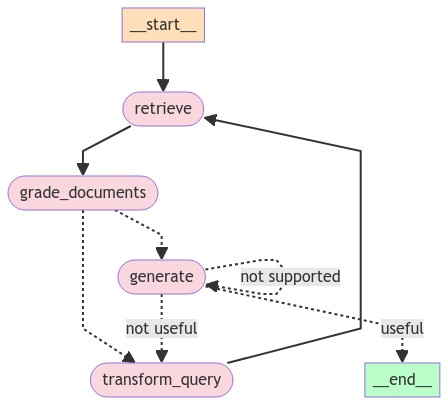

In [47]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph(xray=True).draw_mermaid_png()))
except:
    # This requires some extra dependencies and is optional
    pass